In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import requests
import torchvision

In [2]:
# --- Гиперпараметры ---
BATCH_SIZE = 64
LATENT_DIM = 128
IMAGE_SIZE = 256  # Можно менять: 64, 128, 256 (должно делиться на 16)
EPOCHS = 30
LEARNING_RATE = 1e-3
SAVE_PATH = 'vae_model.pth'
OLD_MODEL = False  # Указать путь к модели для загрузки, если нужно

In [3]:
# --- Устройство ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# --- Подготовка данных ---
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

In [5]:
dataset = datasets.ImageFolder(root='data', transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Loaded {len(dataset)} images from 'data'")

Loaded 1800 images from 'data'


In [6]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, img_size):
        super().__init__()
        assert img_size % 16 == 0, "IMAGE_SIZE должно быть кратно 16"

        num_layers = int(torch.log2(torch.tensor(img_size // 4)))
        layers = []
        in_channels = 3

        for _ in range(num_layers):
            out_channels = in_channels * 2
            layers.append(nn.Conv2d(in_channels, out_channels, 4, 2, 1))
            layers.append(nn.ReLU())
            in_channels = out_channels

        self.conv = nn.Sequential(*layers)
        self.fc_mu = nn.Linear(in_channels * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(in_channels * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


In [7]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, img_size):
        super().__init__()
        assert img_size % 16 == 0, "IMAGE_SIZE должно быть кратно 16"

        num_layers = int(torch.log2(torch.tensor(img_size // 4)))
        self.start_channels = 3 * (2 ** num_layers)
        self.fc = nn.Linear(latent_dim, self.start_channels * 4 * 4)

        layers = []
        in_channels = self.start_channels

        for _ in range(num_layers):
            out_channels = in_channels // 2
            layers.append(nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1))
            layers.append(nn.ReLU())
            in_channels = out_channels

        # Последний слой заменяем на вывод 3 каналов (RGB) + Sigmoid
        layers[-2] = nn.ConvTranspose2d(in_channels * 2, 3, 4, 2, 1)  # out_channels * 2 -> вернем правильный размер
        layers[-1] = nn.Sigmoid()

        self.deconv = nn.Sequential(*layers)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, self.start_channels, 4, 4)
        x = self.deconv(x)
        return x


In [8]:
class VAE(nn.Module):
    def __init__(self, latent_dim, img_size):
        super().__init__()
        self.encoder = Encoder(latent_dim, img_size)
        self.decoder = Decoder(latent_dim, img_size)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

In [9]:
# --- Функция потерь ---
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [10]:
# --- Функции для визуализации ---
def plot_loss(losses):
    plt.figure(figsize=(8, 6))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Значение потерь')
    plt.title('График изменения потерь в процессе обучения')
    plt.legend()
    plt.show()

def imshow(img):
    img = np.array(img)
    if img.min() < 0:
        img -= img.min()
        img /= img.max()
    plt.figure(figsize=(8, 24))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [11]:
# --- Инициализация и загрузка модели ---
vae = VAE(LATENT_DIM, IMAGE_SIZE).to(device)

if OLD_MODEL:
    print(f"Loading model from {OLD_MODEL}")
    vae.load_state_dict(torch.load(OLD_MODEL, map_location=device))
    print("Model loaded successfully.")

optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE)

In [23]:
# --- Обучение ---
losses = []
for epoch in range(EPOCHS):
    vae.train()
    train_loss = 0
    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        recon_imgs, mu, logvar = vae(imgs)
        loss = loss_function(recon_imgs, imgs, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(dataset)
    losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{EPOCHS}] - Training Loss: {avg_loss:.4f}')

Epoch [1/30] - Training Loss: 1381.0928
Epoch [2/30] - Training Loss: 1330.6669
Epoch [3/30] - Training Loss: 1318.3630
Epoch [4/30] - Training Loss: 1305.9331
Epoch [5/30] - Training Loss: 1346.7298
Epoch [6/30] - Training Loss: 1288.4271
Epoch [7/30] - Training Loss: 1262.0422
Epoch [8/30] - Training Loss: 1252.7982
Epoch [9/30] - Training Loss: 1229.1099
Epoch [10/30] - Training Loss: 1222.7988
Epoch [11/30] - Training Loss: 1238.1885
Epoch [12/30] - Training Loss: 1280.0134
Epoch [13/30] - Training Loss: 1345.4482
Epoch [14/30] - Training Loss: 1216.2545
Epoch [15/30] - Training Loss: 1198.3729
Epoch [16/30] - Training Loss: 1154.1382
Epoch [17/30] - Training Loss: 1142.9488
Epoch [18/30] - Training Loss: 1145.6324
Epoch [19/30] - Training Loss: 1141.7428
Epoch [20/30] - Training Loss: 1121.5915
Epoch [21/30] - Training Loss: 1111.8232
Epoch [22/30] - Training Loss: 1098.9444
Epoch [23/30] - Training Loss: 1087.1691
Epoch [24/30] - Training Loss: 1083.4918
Epoch [25/30] - Training 

In [24]:
# --- Сохранение модели ---
torch.save(vae.state_dict(), SAVE_PATH)
print(f"Model saved to {SAVE_PATH}")

Model saved to vae_model.pth


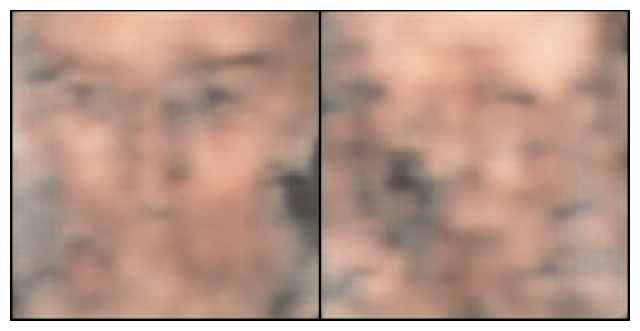

Generated faces saved to 'generated_faces.png'


In [44]:
# --- Генерация новых лиц ---

NUM_PIC = 2

vae.eval()
with torch.no_grad():
    z = torch.randn(NUM_PIC, LATENT_DIM).to(device)
    samples = vae.decoder(z)
imshow(torchvision.utils.make_grid(samples.cpu()))
vutils.save_image(samples.cpu(), 'generated_faces.png', nrow=4)
print("Generated faces saved to 'generated_faces.png'")

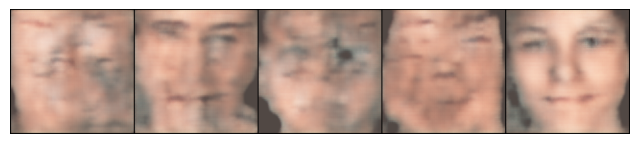

In [ ]:

imshow(torchvision.utils.make_grid(samples.cpu()))


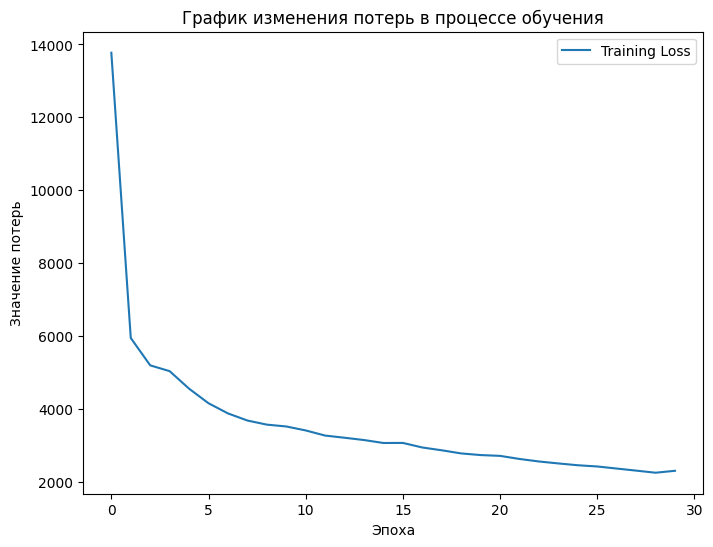

In [16]:
# --- Визуализация графика потерь ---
plot_loss(losses)

In [17]:
# --- Уведомление о завершении обучения ---
url = "http://home.teyhd.ru:3334/"
params = {"msg": f"Обучение автоэнкодера завершено: Эпох {EPOCHS}\nФинальный лосс: {losses[-1]:.6f}"}
try:
    response = requests.get(url, params=params)
    print(f"Notification sent! Status Code: {response.status_code} | Response Text: {response.text}")
except Exception as e:
    print(f"Failed to send notification: {e}")


Notification sent! Status Code: 200 | Response Text: SENDING


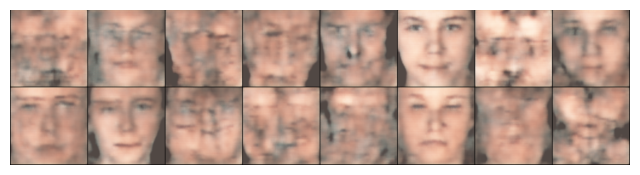

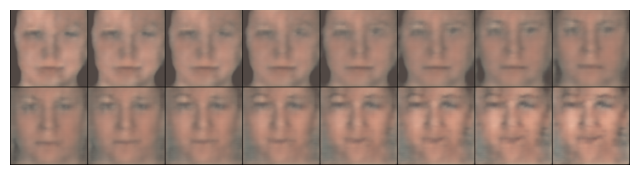

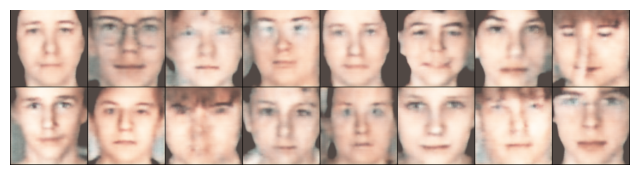

C:\Users\mit\AppData\Local\Temp\ipykernel_6896\681491394.py:81: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(img_path))


GIF морфинга сохранён как 'morphing.gif'


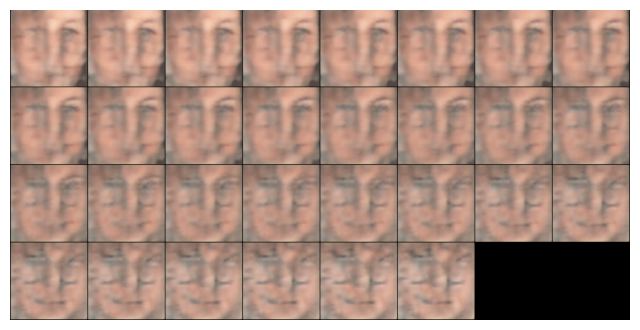

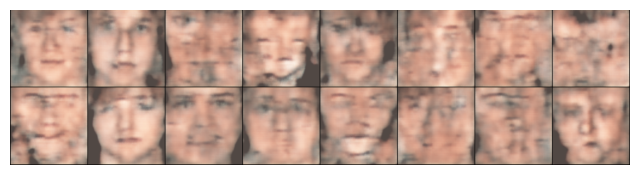

In [47]:
# Продолжение для работы с обученным VAE
# Генерация разных типов z для декодера и создание GIF морфинга

import os
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import requests
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import imageio

# --- Функции визуализации ---
def imshow(img):
    img = np.array(img)
    if img.min() < 0:
        img -= img.min()
        img /= img.max()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# --- Настройки ---
NUM_PIC = 16  # Количество изображений
LATENT_DIM = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Предполагаем, что модель уже загружена как "vae"
vae.eval()

# Папка для сохранения промежуточных картинок
os.makedirs('morph_frames', exist_ok=True)

# --- 1. Стандартное сэмплирование (N(0,1)) ---
with torch.no_grad():
    z = torch.randn(NUM_PIC, LATENT_DIM).to(DEVICE)
    samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), 'z_random_normal.png', nrow=4)
    imshow(torchvision.utils.make_grid(samples.cpu()))

# --- 2. Ручное задание признаков ---
with torch.no_grad():
    z = torch.zeros(NUM_PIC, LATENT_DIM).to(DEVICE)
    z[:, :2] = torch.linspace(-3, 3, NUM_PIC).unsqueeze(1).repeat(1, 2)
    samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), 'z_manual_features.png', nrow=4)
    imshow(torchvision.utils.make_grid(samples.cpu()))

# --- 3. Латентные коды реальных изображений ---
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])
real_dataset = datasets.ImageFolder(root='data', transform=transform)
real_loader = DataLoader(real_dataset, batch_size=NUM_PIC, shuffle=True)

real_imgs, _ = next(iter(real_loader))
real_imgs = real_imgs.to(DEVICE)

with torch.no_grad():
    mu, logvar = vae.encoder(real_imgs)
    z = vae.reparameterize(mu, logvar)
    samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), 'z_from_real_imgs.png', nrow=4)
    imshow(torchvision.utils.make_grid(samples.cpu()))

# --- 4. Интерполяция между двумя точками ---
frames = []
with torch.no_grad():
    z1 = torch.randn(1, LATENT_DIM).to(DEVICE)
    z2 = torch.randn(1, LATENT_DIM).to(DEVICE)
    alphas = torch.linspace(0, 1, steps=30).unsqueeze(1).to(DEVICE)
    z = (1 - alphas) * z1 + alphas * z2
    for i, zi in enumerate(z):
        sample = vae.decoder(zi.unsqueeze(0))
        img_path = f'morph_frames/frame_{i:03d}.png'
        vutils.save_image(sample.cpu(), img_path, nrow=1)
        frames.append(imageio.imread(img_path))
    imageio.mimsave('morphing.gif', frames, fps=10)
    print("GIF морфинга сохранён как 'morphing.gif'")

# Показываем последний батч интерполяции
vutils.save_image(vae.decoder(z).cpu(), 'z_interpolation.png', nrow=6)
imshow(torchvision.utils.make_grid(vae.decoder(z).cpu()))

# --- 5. Альтернативное распределение (равномерное) ---
with torch.no_grad():
    z = torch.empty(NUM_PIC, LATENT_DIM).uniform_(-2, 2).to(DEVICE)
    samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), 'z_uniform_distribution.png', nrow=4)
    imshow(torchvision.utils.make_grid(samples.cpu()))


Сетка лиц сохранена в grid_faces_0_1.png


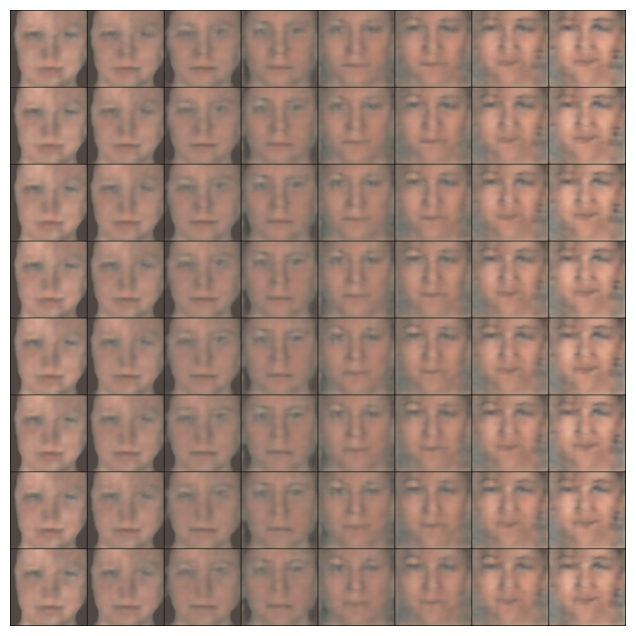

Сетка лиц сохранена в grid_faces_2_3.png


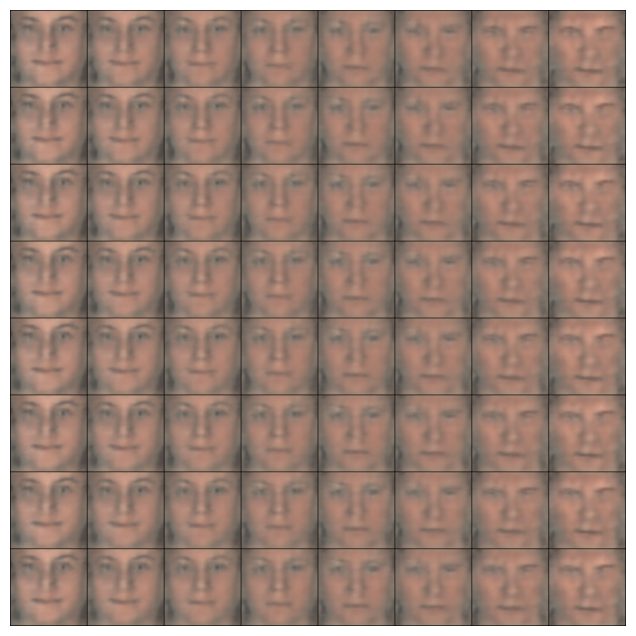

Сетка лиц сохранена в grid_faces_5_6.png


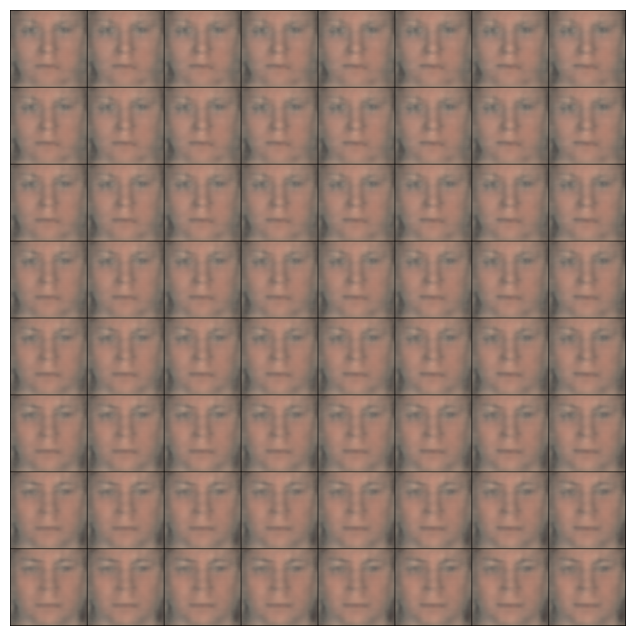

C:\Users\mit\AppData\Local\Temp\ipykernel_6896\4166612776.py:66: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(img_path))


Анимация латентного перехода сохранена в latent_walk.gif


In [46]:
# Код для удобного подбора ручных признаков и генерации 2D-сетки лиц + анимация

import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import os
import imageio

# --- Настройки ---
LATENT_DIM = 128
GRID_SIZE = 8  # Сетка GRID_SIZE x GRID_SIZE
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Предполагаем, что модель VAE уже загружена и называется "vae"
vae.eval()

# --- Удобный подбор параметров ---
def generate_manual_z(fixed_value=0.0, vary_dims=(0, 1), range_min=-3, range_max=3, grid_size=GRID_SIZE):
    total = grid_size * grid_size
    z = torch.full((total, LATENT_DIM), fixed_value).to(DEVICE)
    values = torch.linspace(range_min, range_max, steps=grid_size)
    grid = torch.cartesian_prod(values, values)
    for idx, (val_x, val_y) in enumerate(grid):
        z[idx, vary_dims[0]] = val_x
        z[idx, vary_dims[1]] = val_y
    return z

# --- Генерация 2D-сетки лиц ---
def generate_face_grid(z, save_path='grid_faces.png', grid_size=GRID_SIZE):
    with torch.no_grad():
        samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), save_path, nrow=grid_size)
    print(f"Сетка лиц сохранена в {save_path}")
    imshow(torchvision.utils.make_grid(samples.cpu(), nrow=grid_size))

# --- Функция отображения изображений ---
def imshow(img):
    img = np.array(img)
    if img.min() < 0:
        img -= img.min()
        img /= img.max()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# --- Анимация перемещения по латентному пространству ---
def generate_latent_animation(vary_dims=(0, 1), steps=30, fixed_value=0.0, range_min=-3, range_max=3, save_path='latent_walk.gif'):
    frames = []
    os.makedirs('latent_frames', exist_ok=True)
    with torch.no_grad():
        for step in range(steps):
            alpha = step / (steps - 1)
            val_x = (1 - alpha) * range_min + alpha * range_max
            val_y = np.sin(alpha * np.pi * 2) * (range_max / 2)

            z = torch.full((1, LATENT_DIM), fixed_value).to(DEVICE)
            z[0, vary_dims[0]] = val_x
            z[0, vary_dims[1]] = val_y

            sample = vae.decoder(z)
            img_path = f'latent_frames/frame_{step:03d}.png'
            vutils.save_image(sample.cpu(), img_path, nrow=1)
            frames.append(imageio.imread(img_path))

    imageio.mimsave(save_path, frames, fps=10)
    print(f"Анимация латентного перехода сохранена в {save_path}")

# --- Примеры использования ---

# 1. Меняем 0-й и 1-й признак
z = generate_manual_z(fixed_value=0.0, vary_dims=(0, 1), range_min=-3, range_max=3)
generate_face_grid(z, save_path='grid_faces_0_1.png')

# 2. Меняем 2-й и 3-й признак
z = generate_manual_z(fixed_value=0.0, vary_dims=(2, 3), range_min=-2, range_max=2)
generate_face_grid(z, save_path='grid_faces_2_3.png')

# 3. Узкий диапазон изменений для тонких вариаций
z = generate_manual_z(fixed_value=0.0, vary_dims=(5, 6), range_min=-1, range_max=1)
generate_face_grid(z, save_path='grid_faces_5_6.png')

# 4. Генерация анимации перемещения по латентному пространству
generate_latent_animation(vary_dims=(0, 1), steps=40, save_path='latent_walk.gif')
